# Collaborative filtering
- Patrick Schaper ()
- Daniel-Alexandru Bejan (474404)

In [28]:
from IPython.core.display import HTML
from movie_display import movie_display
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


## Dataset analysis

In [29]:
# Load into a dataframe
movies = pd.read_csv('./dataset/movies.csv')
links = pd.read_csv('./dataset/links.csv')
ratings = pd.read_csv('./dataset/ratings.csv')
tags = pd.read_csv('./dataset/tags.csv')
df = pd.read_json('./dataset/imdbdata.json', orient='columns')


### Print data 

In [30]:
print(f"Number of ratings: {len(ratings)}")
print(f"Number of unique movieId's: {ratings['movieId'].nunique()}")
print(f"Number of unique users: {ratings['userId'].nunique()}")
print(f"Average number of ratings per user: {round(len(ratings)/ratings['userId'].nunique(), 2)}")
print(f"Average number of ratings per movie: {round(len(ratings)/ratings['movieId'].nunique(), 2)}")

Number of ratings: 100004
Number of unique movieId's: 9066
Number of unique users: 671
Average number of ratings per user: 149.04
Average number of ratings per movie: 11.03


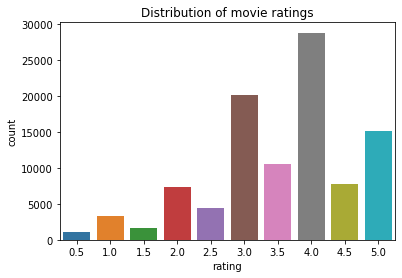

In [31]:
sns.countplot(x="rating", data=ratings)
plt.title("Distribution of movie ratings")
plt.show()

In [32]:
print(f"Mean global rating: {round(ratings['rating'].mean(),2)}.")

mean_ratings = ratings.groupby('userId')['rating'].mean()
print(f"Mean rating per user: {round(mean_ratings.mean(),2)}.")

Mean global rating: 3.54.
Mean rating per user: 3.66.


In [33]:
mean_ratings = ratings.groupby('movieId')[['rating']].mean()
lowest_rated = mean_ratings['rating'].idxmin()
movies[movies['movieId'] == lowest_rated]

,movieId,title,genres
1062,1311,Santa with Muscles (1996),Comedy


In [34]:
highest_rated = mean_ratings['rating'].idxmax()
movies[movies['movieId'] == highest_rated]

,movieId,title,genres
50,53,Lamerica (1994),Adventure|Drama


In [35]:

movie_stats = ratings.groupby('movieId')[['rating']].agg(['count', 'mean'])
movie_stats.columns = movie_stats.columns.droplevel()

In [36]:
C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return bayesian_avg

bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')

In [37]:
movie_stats = movie_stats.merge(movies[['movieId', 'title']])
movie_stats.sort_values('bayesian_avg', ascending=False).head()

,movieId,count,mean,bayesian_avg,title
284,318,311,4.487138,4.446203,"Shawshank Redemption, The (1994)"
695,858,200,4.487500,4.425014,"Godfather, The (1972)"
48,50,201,4.370647,4.314534,"Usual Suspects, The (1995)"
977,1221,135,4.385185,4.302614,"Godfather: Part II, The (1974)"
472,527,244,4.303279,4.259541,Schindler's List (1993)


In [38]:
movie_stats.sort_values('bayesian_avg', ascending=True).head()

,movieId,count,mean,bayesian_avg,title
2869,3593,19,1.210526,1.975099,Battlefield Earth (2000)
1242,1556,23,1.652174,2.183723,Speed 2: Cruise Control (1997)
2161,2701,47,2.031915,2.271446,Wild Wild West (1999)
489,546,17,1.735294,2.347912,Super Mario Bros. (1993)
1243,1562,47,2.148936,2.366224,Batman & Robin (1997)


In [39]:

movies['genres'] = movies['genres'].apply(lambda x: x.split("|"))
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


### Number of movie genres

In [40]:
from collections import Counter

genre_frequency = Counter(g for genres in movies['genres'] for g in genres)

print(f"There are {len(genre_frequency)} genres.")

genre_frequency

There are 20 genres.


Counter({'Adventure': 1117,
         'Animation': 447,
         'Children': 583,
         'Comedy': 3315,
         'Fantasy': 654,
         'Romance': 1545,
         'Drama': 4365,
         'Action': 1545,
         'Crime': 1100,
         'Thriller': 1729,
         'Horror': 877,
         'Mystery': 543,
         'Sci-Fi': 792,
         'Documentary': 495,
         'IMAX': 153,
         'War': 367,
         'Musical': 394,
         'Western': 168,
         'Film-Noir': 133,
         '(no genres listed)': 18})

In [41]:
print("The 5 most common genres: \n", genre_frequency.most_common(5))

The 5 most common genres: 
 [('Drama', 4365), ('Comedy', 3315), ('Thriller', 1729), ('Romance', 1545), ('Action', 1545)]


## User-item matrix

In [42]:
# Create a pivot table with userId as the index, movieId as the columns, and rating as the values
user_item_matrix = ratings.pivot_table(index='userId', columns='movieId', values='rating')

In [43]:
user_item_matrix

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
668,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
669,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Similarity metrics

In [44]:
def prepare_matrix_for_cosine(df, similarity='none'):
    """
    Prepare the datafram for the cosine similarity
    Parameters
    ----------
    df : Pandas Dataframe

    similarity : string
    Returns
    -------
     dataframe : Pandas dataframe
    """
    if similarity == 'none':
        return df.fillna(0)
    if similarity == 'pearson':
        # centered zero matrix
        return df.subtract(df.mean(axis=1), axis=0).fillna(0)   
    if similarity == 'adjusted':
        # Adjusted cosine similarity
        return (df - df.mean()).fillna(0)

#### Calculate similarity matrixes

In [45]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity_matrix = pd.DataFrame(cosine_similarity(prepare_matrix_for_cosine(user_item_matrix)))

pearson_similarity_matrix = pd.DataFrame(cosine_similarity(prepare_matrix_for_cosine(user_item_matrix, 'pearson')))

ajusted_cosine_similarity_matrix = pd.DataFrame(cosine_similarity(prepare_matrix_for_cosine(user_item_matrix, 'adjusted')))

# Example for each similarity

### Cosine Similarity

In [46]:
from sklearn.metrics.pairwise import cosine_similarity
# cosine similarity
cosine_similarity_matrix = pd.DataFrame(cosine_similarity(prepare_matrix_for_cosine(user_item_matrix)))
# calc pearson similarity
pearson_similarity_matrix = pd.DataFrame(cosine_similarity(prepare_matrix_for_cosine(user_item_matrix, 'pearson')))
# calculate adjusted cosine similarity
adjusted_cosine_similarity_matrix = pd.DataFrame(cosine_similarity(prepare_matrix_for_cosine(user_item_matrix, 'adjusted')))

In [49]:
# sns.heatmap(cosine_similarity_matrix, cmap='viridis')
# sns.heatmap(pearson_similarity_matrix, cmap='viridis')
# sns.heatmap(ajusted_cosine_similarity_matrix, cmap='viridis')

#### Calculate the user average

In [50]:

# user_item_matrix.iloc[4][3]
user_item_matrix['average'] = user_item_matrix.mean(axis=1)


## User-user recommendations

#### Converting the user-item matrix to user-user matrix

In [51]:
cosine_similarity_matrix

,0,1,2,3,4,5,6,7,8,9,...,661,662,663,664,665,666,667,668,669,670
0,1.000000,0.000000,0.000000,0.074482,0.016818,0.000000,0.083884,0.000000,0.012843,0.000000,...,0.000000,0.000000,0.014474,0.043719,0.000000,0.000000,0.000000,0.062917,0.000000,0.017466
1,0.000000,1.000000,0.124295,0.118821,0.103646,0.000000,0.212985,0.113190,0.113333,0.043213,...,0.477306,0.063202,0.077745,0.164162,0.466281,0.425462,0.084646,0.024140,0.170595,0.113175
2,0.000000,0.124295,1.000000,0.081640,0.151531,0.060691,0.154714,0.249781,0.134475,0.114672,...,0.161205,0.064198,0.176134,0.158357,0.177098,0.124562,0.124911,0.080984,0.136606,0.170193
3,0.074482,0.118821,0.081640,1.000000,0.130649,0.079648,0.319745,0.191013,0.030417,0.137186,...,0.114319,0.047228,0.136579,0.254030,0.121905,0.088735,0.068483,0.104309,0.054512,0.211609
4,0.016818,0.103646,0.151531,0.130649,1.000000,0.063796,0.095888,0.165712,0.086616,0.032370,...,0.191029,0.021142,0.146173,0.224245,0.139721,0.058252,0.042926,0.038358,0.062642,0.225086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
666,0.000000,0.425462,0.124562,0.088735,0.058252,0.000000,0.232051,0.069005,0.066412,0.032653,...,0.342283,0.050754,0.074080,0.124214,0.351207,1.000000,0.091597,0.018416,0.153111,0.127995
667,0.000000,0.084646,0.124911,0.068483,0.042926,0.019563,0.058773,0.112366,0.194493,0.098561,...,0.074089,0.059010,0.093021,0.082525,0.114487,0.091597,1.000000,0.000000,0.178017,0.135387
668,0.062917,0.024140,0.080984,0.104309,0.038358,0.024583,0.073151,0.055143,0.029291,0.060549,...,0.015960,0.025953,0.077927,0.101707,0.028773,0.018416,0.000000,1.000000,0.042609,0.085202
669,0.000000,0.170595,0.136606,0.054512,0.062642,0.019465,0.096240,0.247687,0.384429,0.158650,...,0.183662,0.122126,0.123407,0.143380,0.159479,0.153111,0.178017,0.042609,1.000000,0.228677


In [111]:
user_id = 1
user_row = cosine_similarity_matrix.loc[1]

updated_df = user_row.drop(1)
updated_df.head()
updated_df.sort_values(ascending=False)

337    0.581528
368    0.580742
150    0.573097
399    0.571252
384    0.565113
         ...   
541    0.000000
539    0.000000
251    0.000000
257    0.000000
0      0.000000
Name: 1, Length: 670, dtype: float64

In [334]:
def get_similar_users(user_id, similarity_strategy='none'):
    """"Create a dict with the most similar users and ranks them based on similarity """
    # get the similarity matrix based similarity strategy
    similarity_matrix = pd.DataFrame(cosine_similarity(prepare_matrix_for_cosine(user_item_matrix, similarity_strategy)))
    # drop the user itself
    similar_users = (similarity_matrix.loc[user_id]).drop(1)
    # sorting the value descending in order to get the most similar users first
    return similar_users.sort_values(ascending=False).head(10)

In [335]:
# testing the method above
# user_id= 2
similar_users = get_similar_users(2)

similar_users

# print(similar_users.index.to_list)


# user_item_matrix.loc[similar_users.index]

# for user_id, similarity in pd.DataFrame(similar_users).iterrows():
#     print(user_id)
    # simlar_user = user_item_matrix.iloc[user_id].dropna()
    # print(simlar_user)

# users_movies = pd.DataFrame(user_item_matrix.iloc[lambda x: x % 2 == 0])
# print(type(users_movies.columns)) 
# droplist = [column for column in users_movies if 1 >= column <= 5]
# print(droplist)
# dropped_columns = users_movies.drop(droplist,inplace=True)

# dropped_columns.head()

2      1.000000
378    0.330205
145    0.306193
512    0.300373
457    0.270742
162    0.268839
93     0.268285
622    0.266702
583    0.265448
63     0.259572
Name: 2, dtype: float64

In [ ]:
 column <= 5]
# print(droplist)
# dropped_columns = users_movies.drop(droplist,inplace=True)

# dropped_columns.head()

In [389]:
def get_recommendation_list(user_id, number_of_recommendations, similarity_strategy):
    # get the similar users with the selected similarity strategy as pandas dataframe
    similar_users = get_similar_users(user_id, similarity_strategy)

    # print(similar_users)
    # get pandas dataframe with each users and their movies
    rated_movies_by_user = user_item_matrix.loc[user_id].dropna()
    # users_movies = pd.DataFrame(user_item_matrix.iloc[2])
    initial_recommendation = pd.Series()
    # print(len(similar_users))
    for user_id, similarity in similar_users.items():
        # print(user_id, similarity)
        similar_user = user_item_matrix.loc[user_id].dropna()
         
        for movie_id, rating in similar_user.items():
            if movie_id not in rated_movies_by_user:
                # print('checking', user_id, similarity, movie_id, rating)
                initial_recommendation= pd.concat([initial_recommendation, pd.Series([rating * similarity], index=[movie_id])])

    recommendations = initial_recommendation.sort_values(ascending=False).head(number_of_recommendations)
    # print(initial_recommendation)
    return recommendations

In [392]:
get_recommendation_list(1, 10, 'none')

C:\Users\alexb\AppData\Local\Temp\ipykernel_29572\1332810665.py:9: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  initial_recommendation = pd.Series()


589     2.936953
1196    2.936953
1199    2.936953
329     2.936953
1356    2.936953
3429    2.934262
541     2.934262
3948    2.934262
3176    2.934262
2858    2.934262
dtype: float64

### Widgets

In [67]:
from IPython.core.display_functions import clear_output
import ipywidgets as widgets

selected_user = widgets.Dropdown(
    options=list(x+1 for x in range(ratings['userId'].nunique())),
    description='Select a user:\n ',
    disabled=False,
    layout={'width': 'max-content'}
)
recommendations = widgets.IntText(
    min=0,
    value=3,
    description='Number of recommendations:\n ',
    disabled=False,
)
similarity_strategy = widgets.RadioButtons(
    options=[('Cosine',0), ('Pearson',1), ('Adjusted cosine',2)],
    description='Similarity metrics:',
    disabled=False
)
button = widgets.Button(
    description='Recommendation',
    disabled=False,
)

def execute_function(_):
    with out:
          clear_output()
          recommendation_titles = []
          if similarity_strategy.value == 0:
              recommendation_list = get_recommendation_list(selected_user.value, recommendations.value, similarity_strategy='none')
          if similarity_strategy.value == 1:
              recommendation_list = get_recommendation_list(selected_user.value, recommendations.value, similarity_strategy='pearson')
          if similarity_strategy.value == 2:
              recommendation_list = get_recommendation_list(selected_user.value, recommendations.value, similarity_strategy='adjusted')
          for movie in recommendation_list:
            recommendation_titles.append(movie[0])
            
          print("Selected User:")
          display(HTML(movie_display.show([df.iloc[selected_user.value]])))
            
          print("Recommendation(s):")
        #   display(showMovieInHtml(recommendation_titles))
            
button.on_click(execute_function)
out = widgets.Output()

box = widgets.VBox([selected_user, similarity_strategy, recommendations, button, out])
box

## Item-item recommendations

1. Select a user
2. Select the movies that the user has rated more than 3.5 stars
3. Based on the user 

In [54]:
# Your code